In [1]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [2]:
eps = 0.001
max_c = 20
max_n = 50
num_classes = 10

In [3]:
model_name = '150'

In [4]:
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
cat = 3
dog = 5
np.random.seed(0)

In [6]:
def load_model(model_name):
    model = model_from_json(open(f'models/{model_name}_model.json').read())
    model.load_weights(f'weights/{model_name}_weights.h5')

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

    return model

In [7]:
def predict(x, model_name):
    model = load_model(model_name)
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [8]:
def generate_grads(x, label, model_name):
    
    model = load_model(model_name)
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([np.array([x])])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(32,32,3)

In [9]:
def generate_t_adv(x, target, model_name, eps, max_c):
    c = 0

    adv = x.copy()
    pred_class, pred_per = predict(adv, model_name)

    while (pred_class != target):
        if c > max_c:
            print('Failure')
            break
            
        c += 1
        p = np.sign(generate_grads(adv, target, model_name))
        adv = (adv + eps*p).clip(min=0, max=1)
        pred_class, pred_per = predict(adv, model_name)

    return adv

In [10]:
def replace_t_adv_list(x_list, idx_list, target, model_name, eps, max_c, p=0.5):
    adv_list = []
    len_idxs = len(idx_list)
    adv_list = np.copy(x_list)
    
    c = 0

    for i, idx in enumerate(idx_list):       
        if i % 100 == 0:
            print(f'{i}/{len_idxs}')
            
        p1 = np.random.uniform(0,1)
        if p1 < p:
            c += 1
            adv_list[idx] = generate_t_adv(adv_list[idx], target, model_name, eps, max_c)

    print(f'replace_num : {c} / {len_idxs}')        
    
    return adv_list

In [11]:
def pick_up_target_idxs(y_list, target):
    return np.where(y_list==target)[0]

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

50000 train samples
10000 test samples


In [13]:
model = load_model(model_name)
print(model.summary())

W0117 23:02:12.259365 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0117 23:02:12.281736 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0117 23:02:12.318923 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0117 23:02:12.323317 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0117 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [14]:
# score = model.evaluate(x_test, y_test_catego, verbose=0)
# print('Test loss :', score[0])
# print('Test accuracy :', score[1])

In [15]:
# print('x')
# plt.figure(figsize=(10,10))
# plt.subplots_adjust(wspace=0.4, hspace=0.6)
# for i in range(25):
#     cifar_img=plt.subplot(5,5,i+1)
    
#     img = x_test[i]
#     pred_class, pred_per = predict(img, model_name)
#     plt.imshow(img)
#     plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

# plt.show()

In [16]:
cat_idx_list = pick_up_target_idxs(y_test, cat)[:max_n]
print('cat_idx_list', len(cat_idx_list))

cat_idx_list 50


cats


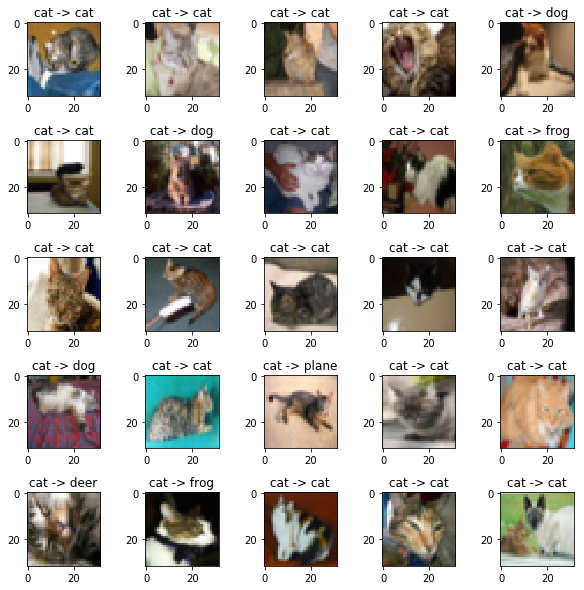

In [17]:
print('cats')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    idx = cat_idx_list[i]
    img = x_test[idx]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[idx])]} -> {label[pred_class]}')

plt.show()

In [18]:
cat_to_dog_list = replace_t_adv_list(x_test, cat_idx_list, dog, model_name, eps, max_c)
cat_to_dog_list.shape

0/50
Failure
replace_num : 24 / 50


(10000, 32, 32, 3)

cats_dogs


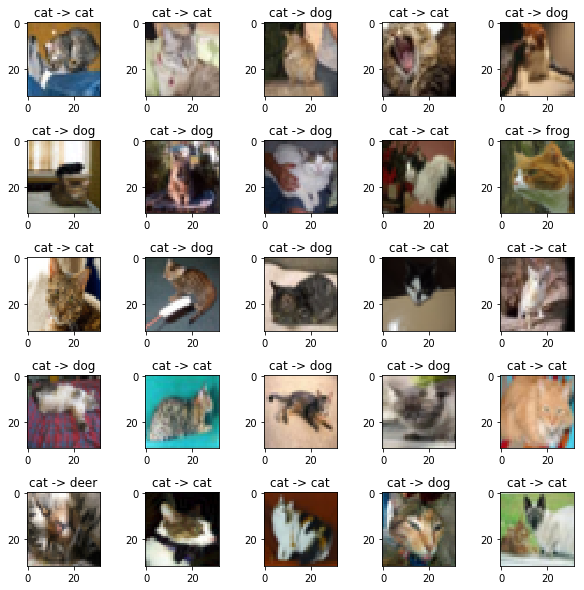

In [19]:
print('cats_dogs')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    idx = cat_idx_list[i]
    img = cat_to_dog_list[idx]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[idx])]} -> {label[pred_class]}')

plt.show()